<div style="text-align: center;">
<img src='lab2_title.png'/>
</div>

# ЛР-2 ММО в АСОИУ (Методы машинного обучения в АСОИУ)

**ИУ5-22М Кириллов Д.С. Вариант 7**

06.04.2024


## Цель лабораторной работы

Изучение продвинутых способов предварительной обработки данных для дальнейшего формирования моделей.


## Задание

1. Выбрать набор данных (датасет), содержащий категориальные и числовые признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.) Просьба не использовать датасет, на котором данная задача решалась в лекции.
2. Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
    1. устранение пропусков в данных;
    2. кодирование категориальных признаков;
    3. нормализация числовых признаков.

## Ход работы


### П.1. Подготовка датасета

#### Датасет Demographic and Socio-economic Indicators

Для пунктов 2.1 и 2.3 взял датасет **Demographic and Socio-economic Indicators - last update: September 2023** https://uis.unesco.org/bdds

В нем собраны различные социально-демографические и экономические метрики с разных стран по годам.

- INDICATOR_ID - код социально-демографической или экономической метрики. Категориальный признак.
- COUNTRY_ID - код государства. Категориальный признак.
- YEAR - год. Категориальный признак.
- VALUE	- значение этой социально-демографической или экономической метрики. Числовой признак.
- MAGNITUDE - пустая колонка
- QUALIFIER - пустая колонка

За некоторые года некоторые метрики могут быть пропущены. Это связано с тем, что расчеты по некоторым показателям не могли быть проведены из-за отсутствия данных. Либо эти данных никто не собирал, как в некоторых странах стретьего мира, либо эти страны имеют закрытую экономику, как Иран и КНДР. Однако, это нельзя считать полноценными пропусками. Если за такой-то год данные по такой-то метрике не были собраны, строка с такой страной, годом и метрикой просто будет отсутствовать. 

Также существует проблема, что данные о стране А собираются с 1900 года, а о стране Б - с 2000.

Для полноценного анализа, **исходный датасет нужно разбить** на более мелкие датасеты либо по исследуемой социально-демографической или экономической метрике, либо по стране.

В работе **буду искусственно внедрять пропуски**. Это проще, чем учитывать, что в такой-то из 241 стран в такой-то год произошли такие-то события, и потому данные за этот год можно считать пропуском.

#### Датасет рестораны

Предыдущий датасет не содержит категориальных признаков кроме страны и года. Страна уже закодирована числовым кодом. Год также представлен числом. Поэтому для п.2.2. я взял другой датасет **Restaurant dataset with details** https://www.kaggle.com/datasets/mohdshahnawazaadil/restaurant-dataset


In [115]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
import scipy.stats as stats
import math

%matplotlib inline

In [116]:
data_folder = '../data/'
countries_labels = pd.read_csv(data_folder + 'DEM_COUNTRY.csv')
indicator_labels = pd.read_csv(data_folder + 'DEM_LABEL.csv')
data_raw = pd.read_csv(data_folder + 'DEM_DATA_NATIONAL.csv')

In [117]:
data_raw

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER
0,200101,ABW,1970,5.924000e+01,NaN,NaN
1,200101,ABW,1971,5.897300e+01,NaN,NaN
2,200101,ABW,1972,5.866000e+01,NaN,NaN
3,200101,ABW,1973,5.905100e+01,NaN,NaN
4,200101,ABW,1974,5.968000e+01,NaN,NaN
...,...,...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10,NaN,NaN
303305,XTGOV.IMF,ZWE,2020,1.726850e+11,NaN,NaN
303306,XTGOV.IMF,ZWE,2021,5.583440e+11,NaN,NaN
303307,XTGOV.IMF,ZWE,2022,2.329145e+12,NaN,NaN


Есть строки с большим количеством NaN. Узнаем, есть ли среди них полезные.

In [118]:
data_raw[~data_raw['MAGNITUDE'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


In [119]:
data_raw[~data_raw['QUALIFIER'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


Полезных нет. Эти 2 колонки можно удалить

In [120]:
df = data_raw.dropna(axis='columns', how='all')
df

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE
0,200101,ABW,1970,5.924000e+01
1,200101,ABW,1971,5.897300e+01
2,200101,ABW,1972,5.866000e+01
3,200101,ABW,1973,5.905100e+01
4,200101,ABW,1974,5.968000e+01
...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10
303305,XTGOV.IMF,ZWE,2020,1.726850e+11
303306,XTGOV.IMF,ZWE,2021,5.583440e+11
303307,XTGOV.IMF,ZWE,2022,2.329145e+12


In [121]:
def two_lists_to_dict(keys, values):
  res = {}
  for key in keys:
      for value in values:
          res[key] = value
          values.remove(value)
          break
  return res

countries_labels = countries_labels.to_dict('list')
countries_labels = two_lists_to_dict(countries_labels['COUNTRY_ID'], countries_labels['COUNTRY_NAME_EN'])

indicator_labels = indicator_labels.to_dict('list')
indicator_labels = two_lists_to_dict(indicator_labels['INDICATOR_ID'], indicator_labels['INDICATOR_LABEL_EN'])


In [122]:
print(f'Число стран: {len(countries_labels)} | Число показателей: {len(indicator_labels)}')

Число стран: 241 | Число показателей: 35


In [123]:
indicator_labels

{'200101': 'Total population (thousands)',
 '200144': 'Population aged 15-24 years (thousands)',
 '200151': 'Population aged 65 years or older (thousands)',
 '200343': 'Population aged 14 years or younger (thousands)',
 '200345': 'Population aged 25-64 years (thousands) ',
 'DT.TDS.DECT.GN.ZS': 'Total debt service (% of GNI)',
 'NY.GDP.DEFL.ZS': 'GDP deflator (base year varies by country)',
 'NY.GDP.MKTP.CD': 'GDP (current US$)',
 'NY.GDP.MKTP.CN': 'GDP (current LCU)',
 'NY.GDP.MKTP.KD  ': 'GDP at market prices (constant 2010 US$)',
 'NY.GDP.MKTP.KD.ZG': 'GDP growth (annual %)',
 'NY.GDP.MKTP.KN': 'GDP (constant LCU)',
 'NY.GDP.MKTP.PP.CD': 'GDP, PPP (current international $)',
 'NY.GDP.MKTP.PP.KD': 'GDP, PPP (constant 2011 international $)',
 'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
 'NY.GDP.PCAP.CN': 'GDP per capita (current LCU)',
 'NY.GDP.PCAP.PP.CD': 'GDP per capita, PPP (current international $)',
 'NY.GDP.PCAP.PP.KD': 'GDP per capita, PPP (constant 2011 international $)

#### П.1. Создание пропусков

Т.к. у меня как бы 35 датасетов в одном, и 1 числовой признак Value, то значения Value не отмасштабированы. Это значит, что массив всех значений Value априори не подчиняется какому-то статистическому закону. Проводить восстановление значений будет бессмысленно.

Кроме того, такие абсолютные значения как годовой ВВП у стран могут отличаться на порядки, например, у КНР и Анголы. Для работы **нужно выбрать такие числовые метрики, которые не имели бы такой большой разброс**, например, **ожидаемая средняя продолжительность жизни человека**, или тот же **ВВП**, но **в процентах к предыдущему году**.

In [124]:
values_trash = df[df['INDICATOR_ID'] == "NY.GDP.MKTP.CN"]['VALUE']
values_trash.name = 'ВВП, $'

df1 = df[df['INDICATOR_ID'] == "SP.DYN.LE00.IN"]
df1.index = range(0, df1.shape[0])

values1 = df1['VALUE']
values1.name = 'Продолжительность жизни, лет'


In [125]:
def normalize(df):
  normalized_df=(df-df.min())/(df.max()-df.min())
  return normalized_df

<AxesSubplot:xlabel='Продолжительность жизни, лет', ylabel='Density'>

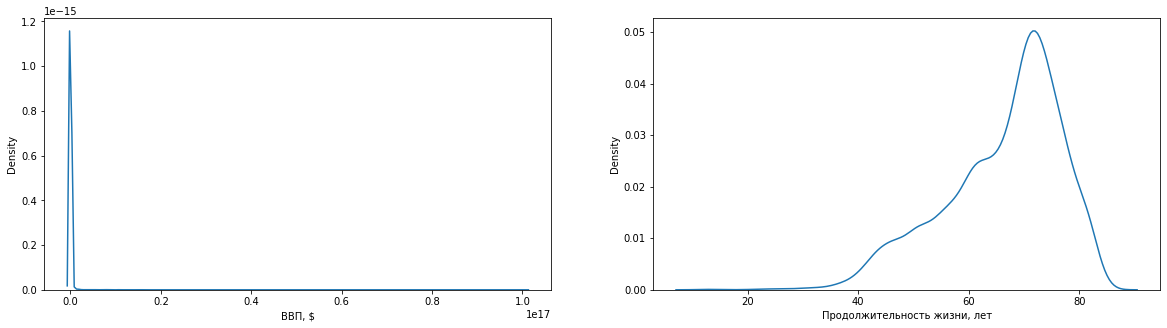

In [126]:
figure, axes = plt.subplots(1, 2, figsize=(20,5))

sns.kdeplot(ax=axes[0], data=values_trash)
sns.kdeplot(ax=axes[1], data=values1)

<AxesSubplot:xlabel='Продолжительность жизни, лет', ylabel='Count'>

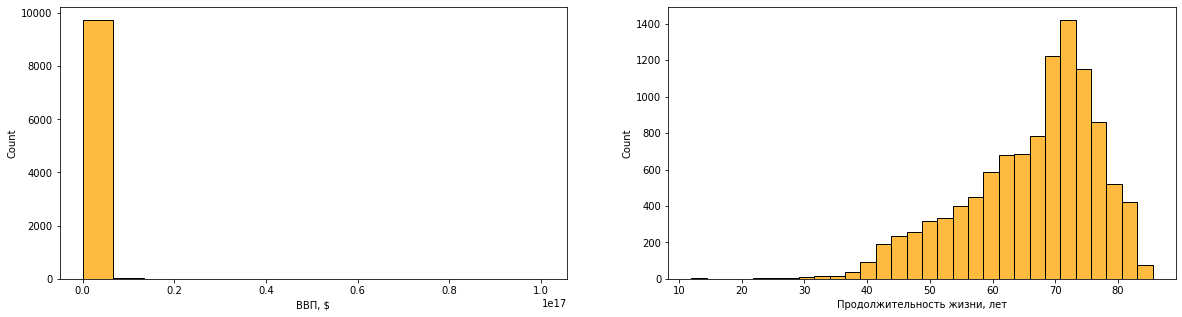

In [127]:
figure, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(ax=axes[0], data=values_trash, bins=15, color='orange')
sns.histplot(ax=axes[1], data=values1, bins=30, color='orange')

Как видно, в "первом датасете" значения "VALUE" несопоставимы. Его рассматривать не буду.

Далее, в качестве первого датасета возьму значения "VALUE", когда "INDICATOR_ID" =="SP.DYN.LE00.IN".

Модифицирую первый датасет так, чтобы в колонке VALUE у меня было не более 5% пропусков.

In [128]:
print(df1.shape)

(10792, 4)


In [129]:
np.random.seed(1999)

n_rows = df1.shape[0]
nan_indeces = np.random.uniform(0, n_rows - 1, int(0.05 * n_rows))
nan_indeces = np.rint(nan_indeces).astype(int)
df1['VALUE'][nan_indeces] = np.NaN

# df.iloc[nan_indeces]['VALUE'] = np.NaN


C:\Users\dturc\AppData\Local\Temp\ipykernel_35848\145377067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['VALUE'][nan_indeces] = np.NaN
c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)


In [130]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10792 entries, 0 to 10791
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   INDICATOR_ID  10792 non-null  object 
 1   COUNTRY_ID    10792 non-null  object 
 2   YEAR          10792 non-null  int64  
 3   VALUE         10261 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 337.4+ KB


Количество пропуском в поцентном соотношении:

In [131]:
(df1.isna().sum() / len(df1)).round(4) * 100

INDICATOR_ID    0.00
COUNTRY_ID      0.00
YEAR            0.00
VALUE           4.92
dtype: float64

### П.2.1. Устранение пропусков в данных

Заполнение (внедрение) значений или импьютация (imputation) - это заполнение пропущенных значений их статистическими оценками.

Для числовых признаков:

- Заполнение показателями центра распределения.
- Заполнение константой. Полезно в случае "неслучайного" распределения пропусков.
- Заполнение "хвостом распределения".

Для категориальных признаков:

- Заполнение наиболее распространенным значением категории (аналогом моды).
- Введение отдельного значения категории для пропущенных значений.

Для числовых и категориальных признаков:
- Добавления флага пропусков.
- Заполнение случайным значением признака. Метод обычно применяют на больших выборках. Преимуществом является то, что он сохраняет дисперсию исходной выборки.

Данное распределение, распределение метрики "ожидаемая средняя продолжительность жизни человека", **похоже на нормальное**.

Это числовой признак. Подходят методы заполнения:
- показателями центра распределения: модой, медианой, математическим ожиданием
- хвостом распределения по формуле для симметричного распредления: $extreme_{value}=mean(f)+3 \cdot std(f)$

In [132]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

<AxesSubplot:ylabel='Density'>

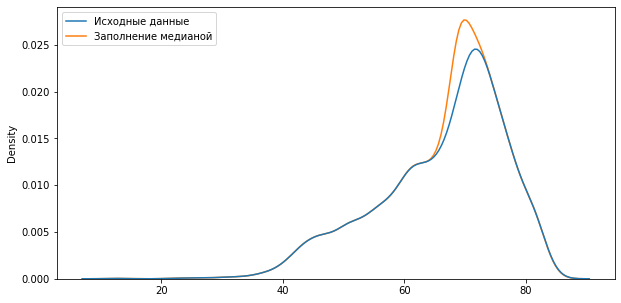

In [133]:
df1_imputed, df1_filled, df1_missed = impute_column(df1, 'VALUE', 'median')

fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(
  ax=ax,
  data=pd.DataFrame({
    'Исходные данные': df1['VALUE'].values,
    'Заполнение медианой': df1_imputed,
  }),
)

In [134]:
print('Было {} пропусков. Было заполнено {} пропусков значением {} (медиана)'.format(df1.isna().sum()['VALUE'], len(df1_filled), df1_filled[0]))


Было 531 пропусков. Было заполнено 531 пропусков значением 68.924 (медиана)


<AxesSubplot:ylabel='Density'>

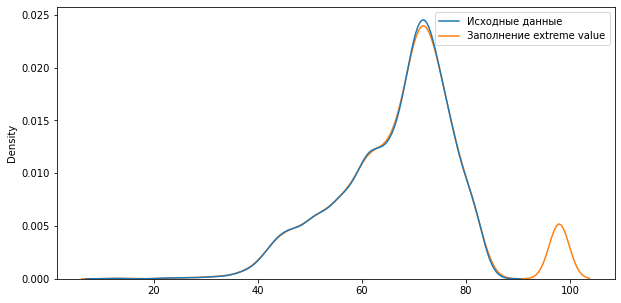

In [135]:
df1_ev = df1['VALUE'].mean() + 3 * df1['VALUE'].std()
df1_imputed_2, df1_filled_2, df1_missed_2 = impute_column(df1, 'VALUE', 'constant', df1_ev)
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(
  ax=ax,
  data=pd.DataFrame({
    'Исходные данные': df1['VALUE'].values,
    'Заполнение extreme value': df1_imputed_2,
  }),
)

In [147]:
print('Было {} пропусков. Было заполнено {} пропусков значением {} (extreme value)'.format(df1.isna().sum()['VALUE'], len(df1_filled_2), df1_filled_2[0]))


Было 531 пропусков. Было заполнено 531 пропусков значением 97.94977058152217 (extreme value)


### П.2.3 Нормализация

In [137]:
china_gdp_df = df[(df['INDICATOR_ID'] == 'NY.GDP.MKTP.KD.ZG') & (df['COUNTRY_ID'] == 'CHN')][['YEAR', 'VALUE']]
china_gdp_df.head()

((array([-2.22641794, -1.85879423, -1.64227002, -1.48323568, -1.35477406,
         -1.2454475 , -1.14926907, -1.06268947, -0.98342046, -0.90989423,
         -0.84098553, -0.77585639, -0.71386359, -0.65450069, -0.59736004,
         -0.54210703, -0.48846216, -0.43618809, -0.38508017, -0.33495933,
         -0.28566657, -0.23705869, -0.18900486, -0.14138379, -0.09408139,
         -0.04698868,  0.        ,  0.04698868,  0.09408139,  0.14138379,
          0.18900486,  0.23705869,  0.28566657,  0.33495933,  0.38508017,
          0.43618809,  0.48846216,  0.54210703,  0.59736004,  0.65450069,
          0.71386359,  0.77585639,  0.84098553,  0.90989423,  0.98342046,
          1.06268947,  1.14926907,  1.2454475 ,  1.35477406,  1.48323568,
          1.64227002,  1.85879423,  2.22641794]),
  array([-1.57   ,  2.23864,  2.31   ,  2.9908 ,  3.81   ,  3.92025,
          4.20633,  5.11276,  5.9505 ,  6.74977,  6.84876,  6.9472 ,
          7.04133,  7.06   ,  7.42576,  7.57   ,  7.59132,  7.66165,
   

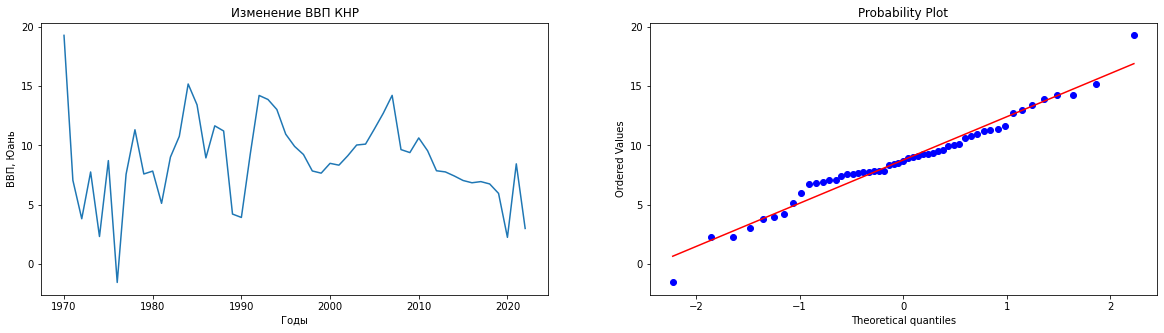

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].title.set_text('Ежегодный рост ВВП КНР')
axs[0].set_xlabel('Годы') # Подпись для оси х
axs[0].set_ylabel('Прирост ВВП, %')
sns.lineplot(x = china_gdp_df['YEAR'].values, y=china_gdp_df['VALUE'].values, ax=axs[0], ) #, drawstyle='steps-pre')
stats.probplot(china_gdp_df['VALUE'].values, dist="norm", plot=axs[1])

На графике есть значения ниже нуля. Методы нормализации, такие как взятие логарифма или корня, не могут быть применены.

Ограничу датасет по годам так, чтобы остались только положительные значения

In [142]:
china_gdp_df = df[(df['INDICATOR_ID'] == 'NY.GDP.MKTP.KD.ZG') & (df['COUNTRY_ID'] == 'CHN') & (df['YEAR'] >= 1978)][['YEAR', 'VALUE']]

In [143]:
def diagnostic_plots(xvalues, yvalues, ax1, ax2, title, xlabel, ylabel):
  ax1.title.set_text(title)
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel(ylabel)
  sns.lineplot(x = xvalues, y = yvalues, ax=ax1, )
  stats.probplot(yvalues, dist="norm", plot=ax2)

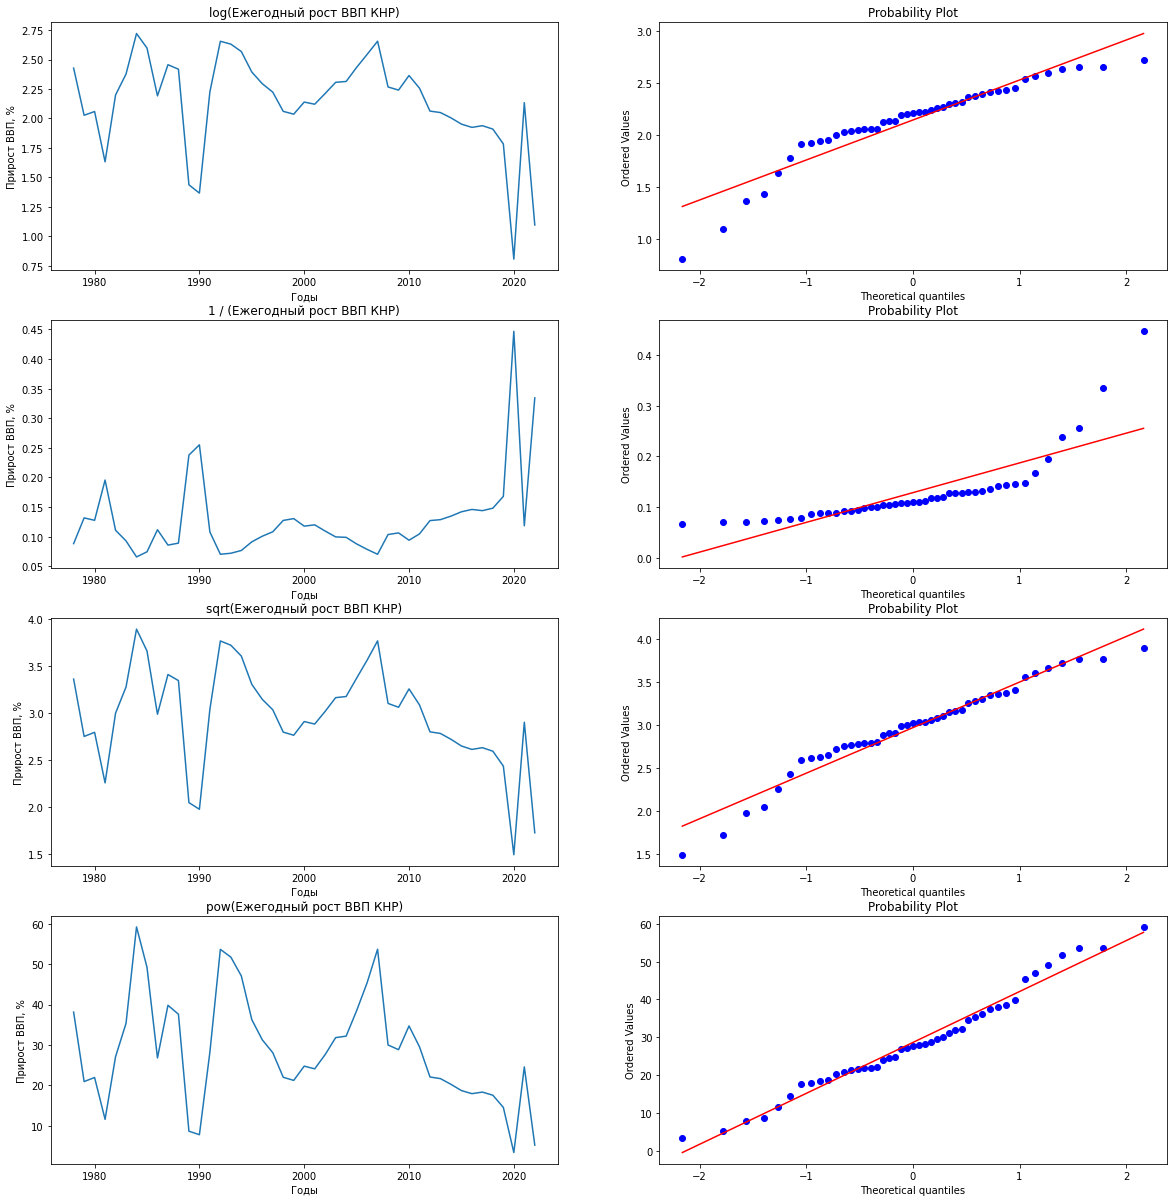

In [146]:
fig, axs = plt.subplots(4, 2, figsize=(20, 21))
diagnostic_plots(china_gdp_df['YEAR'].values, np.log(china_gdp_df['VALUE'].values), axs[0][0], axs[0][1], 'log(Ежегодный рост ВВП КНР)', 'Годы', 'Прирост ВВП, %')
diagnostic_plots(china_gdp_df['YEAR'].values, 1 / china_gdp_df['VALUE'].values, axs[1][0], axs[1][1], '1 / (Ежегодный рост ВВП КНР)', 'Годы', 'Прирост ВВП, %')
diagnostic_plots(china_gdp_df['YEAR'].values, china_gdp_df['VALUE'].values**(1/2), axs[2][0], axs[2][1], 'sqrt(Ежегодный рост ВВП КНР)', 'Годы', 'Прирост ВВП, %')
diagnostic_plots(china_gdp_df['YEAR'].values, china_gdp_df['VALUE'].values**(3/2), axs[3][0], axs[3][1], 'pow(Ежегодный рост ВВП КНР)', 'Годы', 'Прирост ВВП, %')

К сожалению, график такой формы привести к нормальному мне не удалось

### П.2.2. Кодирование категориальных признаков

In [151]:
data_raw_rest = pd.read_csv(data_folder + 'RestaurantDataset .csv')
data_raw_rest.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


Страна уже закодирована, а например, город и тип кухни - нет. Возьмем город

In [152]:
df_rest = data_raw_rest[['Restaurant ID', 'Restaurant Name', 'Country Code',	'City']]
df_rest.head()

,Restaurant ID,Restaurant Name,Country Code,City
0,6317637,Le Petit Souffle,162,Makati City
1,6304287,Izakaya Kikufuji,162,Makati City
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City
3,6318506,Ooma,162,Mandaluyong City
4,6314302,Sambo Kojin,162,Mandaluyong City


In [157]:
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from category_encoders.count import CountEncoder as ce_CountEncoder

In [154]:
le = LabelEncoder()
df_rest['City LE'] = le.fit_transform(df_rest['City'])

df_rest.head()

C:\Users\dturc\AppData\Local\Temp\ipykernel_35848\3905718101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest['City LE'] = le.fit_transform(df_rest['City'])


,Restaurant ID,Restaurant Name,Country Code,City,City LE
0,6317637,Le Petit Souffle,162,Makati City,73
1,6304287,Izakaya Kikufuji,162,Makati City,73
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,75
3,6318506,Ooma,162,Mandaluyong City,75
4,6314302,Sambo Kojin,162,Mandaluyong City,75


In [168]:
df_ohe = pd.merge(df_rest['City'].copy(), pd.get_dummies(df_rest[['City']]), left_index=True, right_index=True)
# df_ohe.head()
df_ohe[df_ohe['City'] == 'Abu Dhabi'].head()

,City,City_Abu Dhabi,City_Agra,City_Ahmedabad,City_Albany,City_Allahabad,City_Amritsar,City_Ankara,City_Armidale,City_Athens,...,City_Vernonia,City_Victor Harbor,City_Vineland Station,City_Vizag,City_Waterloo,City_Weirton,City_Wellington City,City_Winchester Bay,City_Yorkton,City_��stanbul
564,Abu Dhabi,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,Abu Dhabi,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,Abu Dhabi,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,Abu Dhabi,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Abu Dhabi,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
